# Homework 11: 

# Aliza Rafique (ar05986)

#### ar05986@st.habib.edu.pk

## Necessary Imports

In [14]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore") #optional
plt.style.use('fivethirtyeight') #optional
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib
from datetime import datetime
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
data = pd.read_csv('btc-market-price.csv')
data.head()

,Date,Market_Price
0,3/25/2021 0:00,52508.23
1,3/26/2021 0:00,51415.92
2,3/27/2021 0:00,55074.47
3,3/28/2021 0:00,55863.93
4,3/29/2021 0:00,55783.71


In [3]:
# Converting date object to date time
data['Date'] = pd.to_datetime(data['Date'])

## Question 1

In [4]:
# Setting the date as index
data = data.set_index('Date')
data.index

DatetimeIndex(['2021-03-25', '2021-03-26', '2021-03-27', '2021-03-28',
               '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01',
               '2021-04-02', '2021-04-03',
               ...
               '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-19',
               '2022-03-20', '2022-03-21', '2022-03-22', '2022-03-23',
               '2022-03-24', '2022-03-25'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)

### Everyday Trend

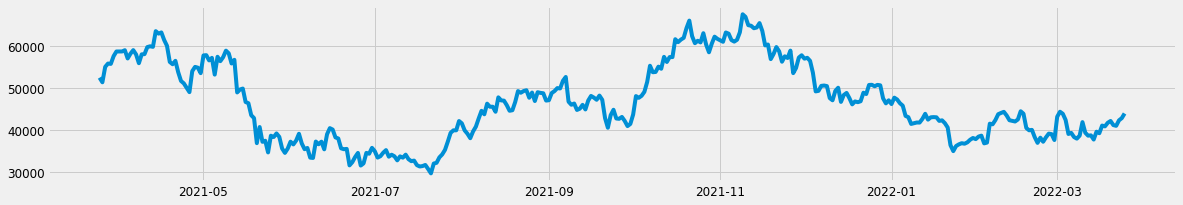

In [6]:
x = data.index
plt.figure(figsize=(18, 3))
plt.plot(x, data['Market_Price'])

There is no prominent everyday trend. The price of Bitcoin is fluctuating with month of November being the highest market price. After this, the price is decreasing overall, being lower than how it started before May. 

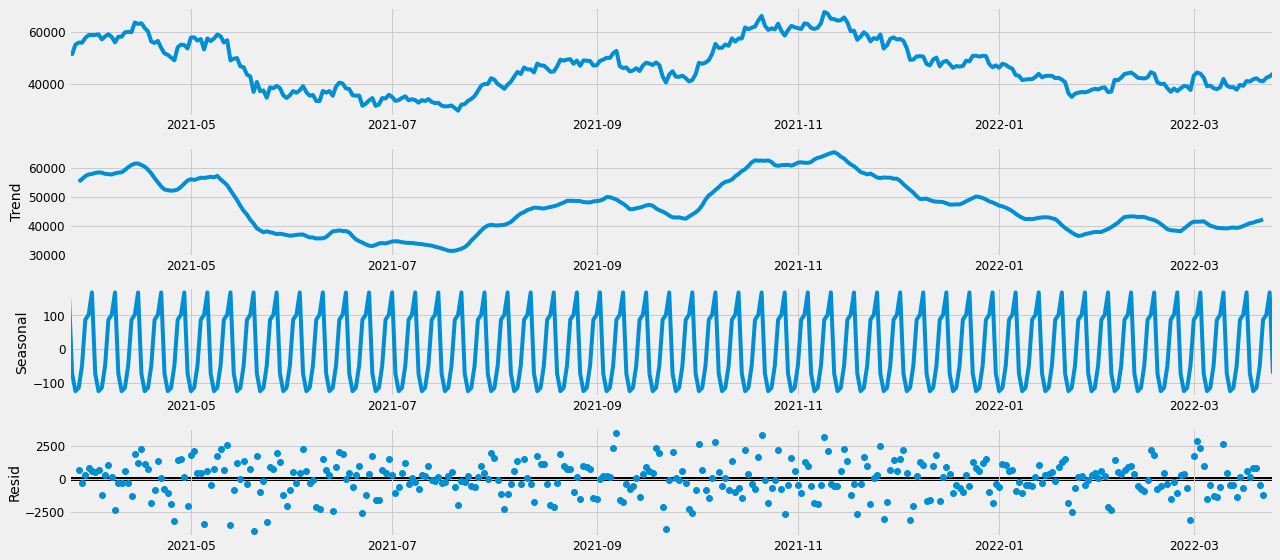

In [7]:
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

### Explanation
From the trend graph, we can see the overall trend which is not periodic and is very similar to the graph I discussed above. In the seasonal graph, with every data point, we can see the increase and decrease in the market price. The residual graph explains the accuracy of prediction value

## Question 2: Splitting data

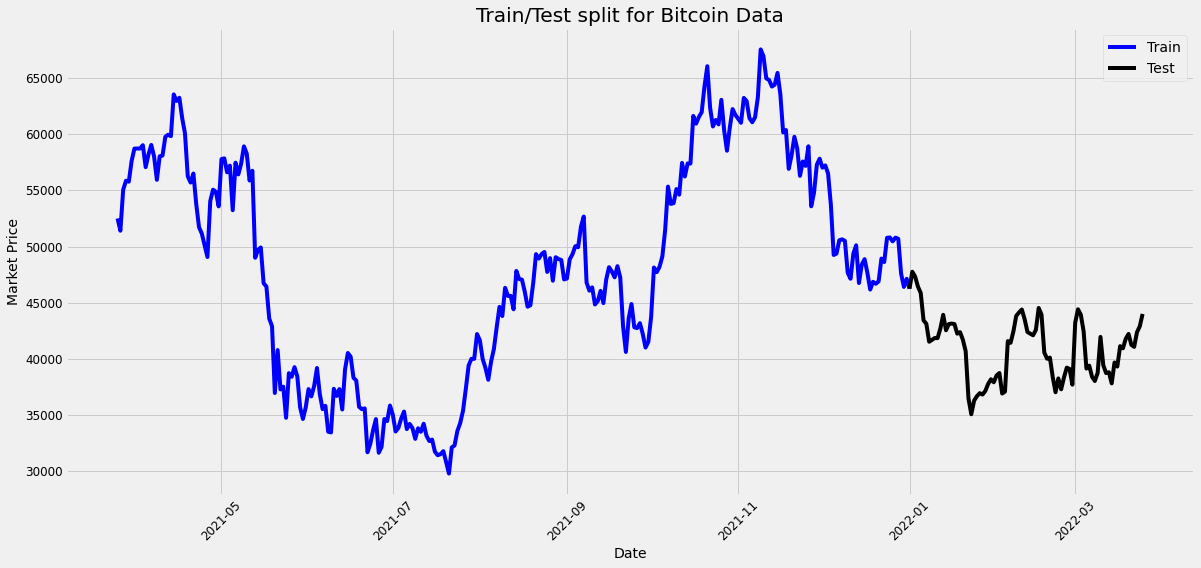

In [96]:
train = data[data.index <= pd.to_datetime("2022-01-01", format='%Y-%m-%d')]
test = data[data.index >= pd.to_datetime("2022-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "blue", label = 'Train')
plt.plot(test, color = "black", label = 'Test')
plt.ylabel('Market Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Bitcoin Data")
plt.legend()
plt.show()

## Question 3: Using ARIMA

In [97]:
from statsmodels.tsa.arima.model import ARIMA

We have (p, d, q) where q is the differencing that we don't calculate (q = 0) if the data is stationary. So, checking now if the data is stationary using adfuller.

In [98]:
result = adfuller(data)
result

(-1.8955897468351197,
 0.3341386689571041,
 0,
 365,
 {'1%': -3.4483935212959844,
  '5%': -2.8694912343676497,
  '10%': -2.571005879151811},
 6200.562628601974)

The p-value is 0.33 > 0.05 so, the data is not stationary. And the value of q is not going to be 0. So, fixing the value of q = 2. Lag, p = 2, and q = 2. We are keeping high values of p d q so that the model learns the spikes better.

In [99]:
def arimafunc(p, d, q):

    ARIMAmodel = ARIMA(train, order = (p, d, q))

    ARIMAmodel = ARIMAmodel.fit()

    y_pred = ARIMAmodel.get_forecast(len(test.index))

    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

    #for plotting purposes
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"] 

    plt.plot(train, color = "blue", label = 'Train')
    plt.plot(test, color = "black", label = 'Test')
    plt.ylabel('Market Price')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.title("Train/Test split for Bitcoin Data")

    plt.plot(y_pred_out, color='red', label = 'Predictions')
    plt.legend()
    plt.show()

    import numpy as np
    from sklearn.metrics import mean_squared_error

    arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
    print("RMSE: ",arma_rmse)

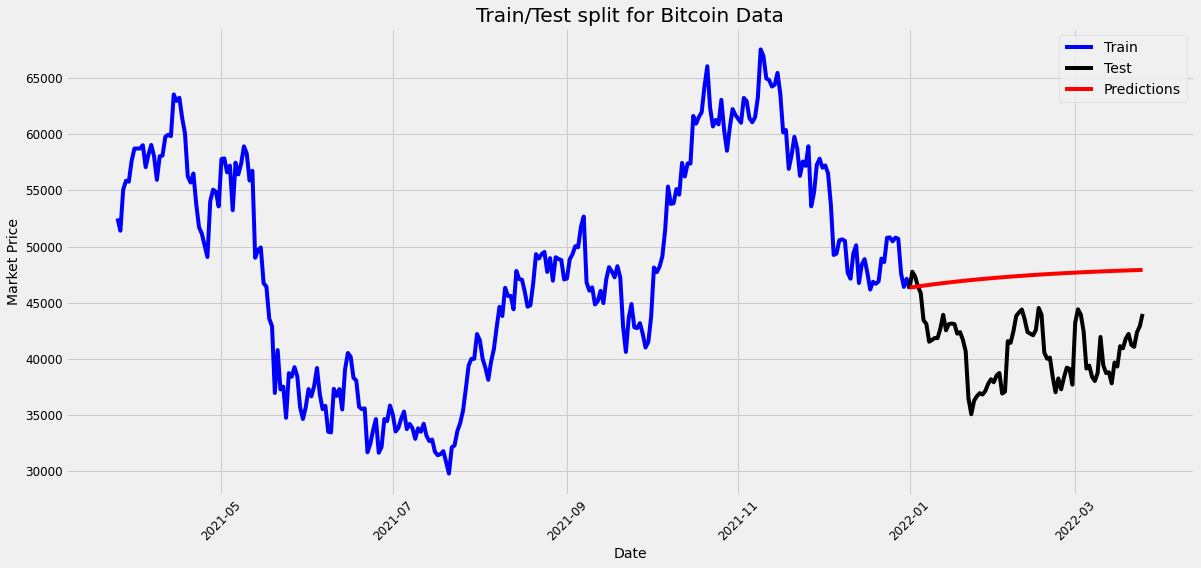

RMSE:  7045.6308372871545


In [100]:
arimafunc(1, 0, 1)

The mean squared error is very high from this model which means we need better values for p, d, and q. 

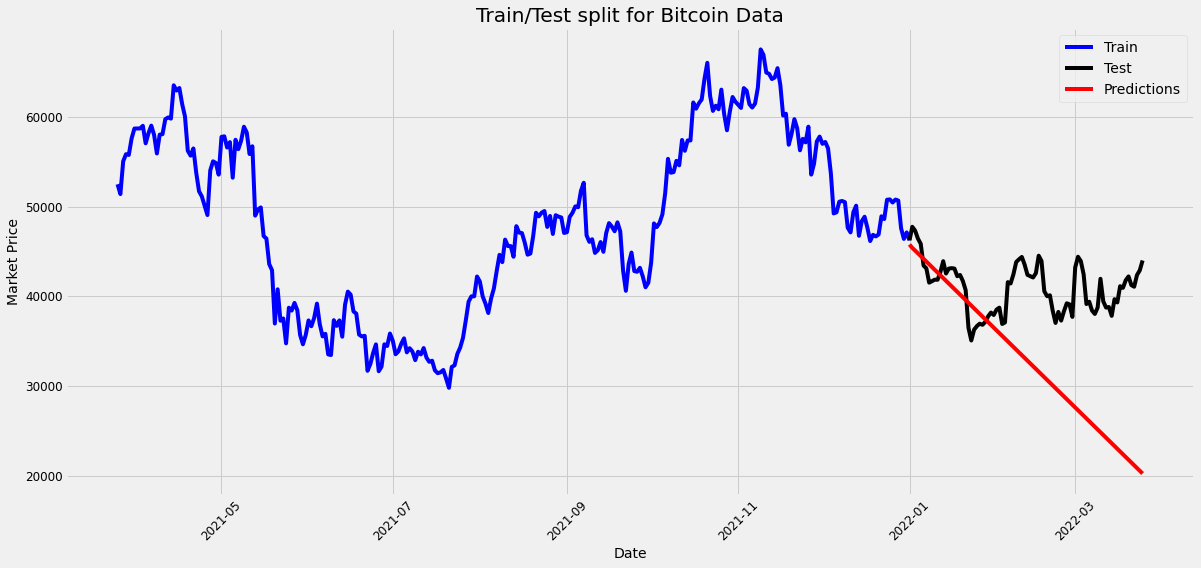

RMSE:  10803.63119327729


In [102]:
arimafunc(3, 2, 2)

The error decreased further but still it is high. 

## Question 4: SARIMA Model

In [103]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

We have here, p, d, and q same as before. But there are additional seasonal elements: P, D, Q, and m.

In [104]:
def sarimafunc(p, d, q, P, D, Q, m):
    SARIMAXmodel = SARIMAX(train,order=(p, d, q),seasonal_order=(P, D, Q, m))
    SARIMAXmodel = SARIMAXmodel.fit()

    y_pred = SARIMAXmodel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"] 

    plt.plot(train, color = "blue", label = 'Train')
    plt.plot(test, color = "black", label = 'Test')
    plt.ylabel('Market Price')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.title("Train/Test split for Bitcoin Data")

    plt.plot(y_pred_out, color='red', label = 'Predictions')
    plt.legend()
    plt.show()

    import numpy as np
    from sklearn.metrics import mean_squared_error

    arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
    print("RMSE: ",arma_rmse)

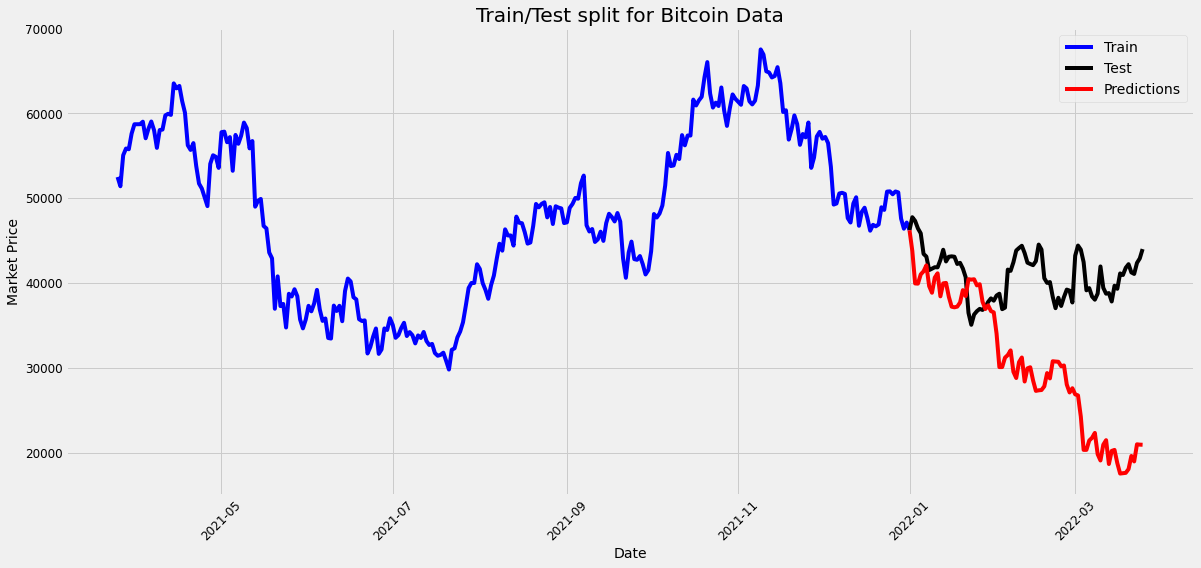

RMSE:  13149.679543973809


In [105]:
sarimafunc(1, 1, 1, 1, 1, 0, 30)

We can see that it is showing the fluctuations which are important as the bitcoin data also has a fluctuating market price. However, the prediction is still not very close to actual values as the mean squared error is very high. So, we need to find optimal parameters and for that we will do a grid search:

## Question 5

### Grid Search

In [106]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]

In [107]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 30)12 - AIC:6896.675317036195
ARIMA(0, 0, 0)x(0, 0, 1, 30)12 - AIC:5996.136641668485
ARIMA(0, 0, 0)x(0, 1, 0, 30)12 - AIC:5392.439338345183
ARIMA(0, 0, 0)x(0, 1, 1, 30)12 - AIC:4754.247972901741
ARIMA(0, 0, 0)x(1, 0, 0, 30)12 - AIC:5401.778120422718
ARIMA(0, 0, 0)x(1, 0, 1, 30)12 - AIC:5373.825109576674
ARIMA(0, 0, 0)x(1, 1, 0, 30)12 - AIC:4778.387179456952
ARIMA(0, 0, 0)x(1, 1, 1, 30)12 - AIC:4749.759034773308
ARIMA(0, 0, 1)x(0, 0, 0, 30)12 - AIC:6669.573841282504
ARIMA(0, 0, 1)x(0, 0, 1, 30)12 - AIC:5917.206678967497
ARIMA(0, 0, 1)x(0, 1, 0, 30)12 - AIC:5213.824018162732
ARIMA(0, 0, 1)x(0, 1, 1, 30)12 - AIC:4567.6874951048985
ARIMA(0, 0, 1)x(1, 0, 0, 30)12 - AIC:5942.5787054659995
ARIMA(0, 0, 1)x(1, 0, 1, 30)12 - AIC:5897.307343916197
ARIMA(0, 0, 1)x(1, 1, 0, 30)12 - AIC:4628.247779162117
ARIMA(0, 0, 1)x(1, 1, 1, 30)12 - AIC:4587.558341555316
ARIMA(0, 1, 0)x(0, 0, 0, 30)12 - AIC:5032.643611008863
ARIMA(0, 1, 0)x(0, 0, 1, 30)12 - AIC:4502.89799408231
ARIMA(0, 

Now, out of all these possible parameters, we will pick the one with the lowest mean squared error which is 3978 corresponding to (0, 1, 1, 0, 1, 1, 30) (it has two possible values but this one has lowest rmse). 

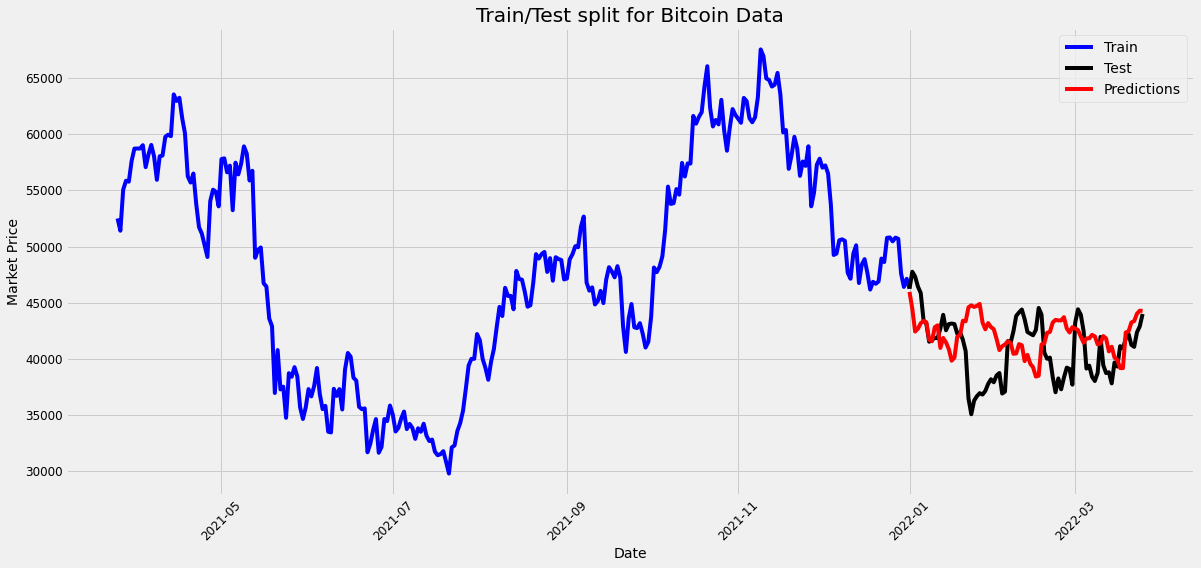

RMSE:  3636.0655719089764


In [108]:
#sarimafunc(1, 1, 1, 0, 1, 1, 30)
# sarimafunc(0, 1, 1, 0, 1, 1, 30) #optimal
sarimafunc(1, 1, 1, 1, 1, 1, 30) # random pick - AIC: 3979

For the lowest AIC value, rmse is not the lowest (confusingly). So, I randomly picked other combination that did give me better results. We can also see that the prediction is getting closer to the actual data.

### Comparison of SARIMAX and ARIMA
As we can see from RMSE value of SARIMAX, 3636 it is better than the RMSE value of 10803 for ARIMA. SARIMAX is the better model for the prediction. Moreover, ARIMA model is just considering the prediction linearly whereas we can see that the data has a lot of fluctuations so SARIMAX is also doing a good job in identifying spikes and fluctuations.

## Question 6

In [111]:
# extract the seasonality data
months = [x.month for x in train.index]
years = [x.year for x in train.index]
day = [x.day for x in train.index]
 
# convert into one matrix
X = np.array([day, months, years]).T
Y = train.values
X = np.array([day, months, years]).T
Y = train.values

In [112]:
# extract the day, month and year data
tmonths = [x.month for x in test.index]
tyears = [x.year for x in test.index]
tday = [x.day for x in test.index]
 
# convert into one matrix
testX = np.array([tday, tmonths, tyears]).T
testY = test.values

### Random Forest

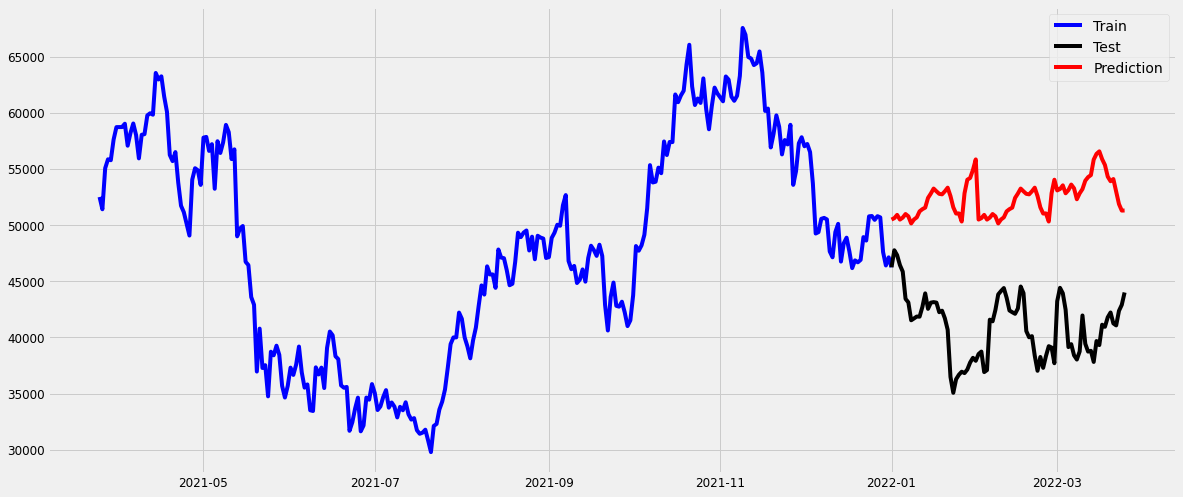

RMSE:  12014.093428344291


In [113]:
from sklearn.ensemble import RandomForestRegressor
 
# fit the model
rfmodel = RandomForestRegressor()
rfmodel.fit(X,Y)
 
# predict on the same period
preds = rfmodel.predict(testX)
 
# plot what has been learned
plt.plot(train.index, train.values,color="blue", label='Train')
plt.plot(test.index, test.values,color="black", label='Test')
plt.plot(test.index, preds, color="red",label='Prediction')
plt.legend()
plt.show()
rf_rmse = np.sqrt(mean_squared_error(test.values, preds))
print("RMSE: ",rf_rmse)

### Decision Tree Regressor

In [114]:
from sklearn.tree import DecisionTreeRegressor 

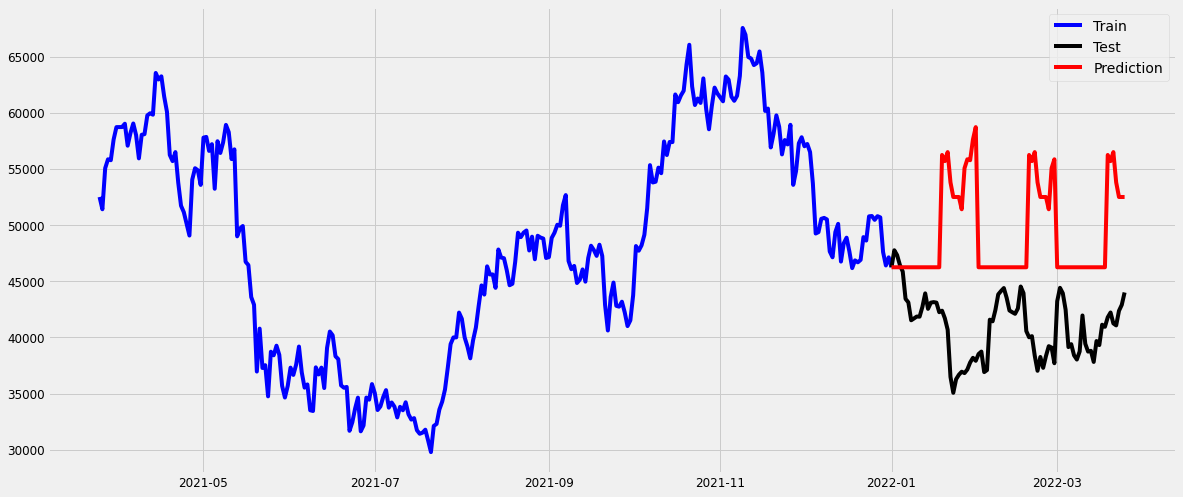

RMSE:  10165.864617282754


In [115]:
regressor = DecisionTreeRegressor(random_state = 99)
regressor.fit(X, Y)

preds = regressor.predict(testX)

# plot what has been learned
plt.plot(train.index, train.values,color="blue", label='Train')
plt.plot(test.index, test.values,color="black", label='Test')
plt.plot(test.index, preds, color="red",label='Prediction')
plt.legend()
plt.show()
rf_rmse = np.sqrt(mean_squared_error(test.values, preds))
print("RMSE: ",rf_rmse)

## Question 7

### Comparison
Out of ARIMA, SARIMAX, Random Forest Regressor, and Decision Tree Regressor, SARIMAX turns out to be the best. It has the lowest value of RMSE as compared to the values of all. Although, SARIMAX gives repetitive fluctuations and in terms of that Random Forest Regressor provides better fluctuations, the predicted values of SARIMAX are still better than that of Random Forest Regressor. 

## Question 8: Prediction Price using SARIMAX Model

In [116]:
dates = pd.date_range(start='01/04/2022', end='30/06/2022')

In [119]:
t_months = [x.month for x in dates]
t_years = [x.year for x in dates]
t_day = [x.day for x in dates]

### Getting Optimal Parameters

In [125]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]

In [126]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 30)12 - AIC:6896.675317036195
ARIMA(0, 0, 0)x(0, 0, 1, 30)12 - AIC:5996.136641668485
ARIMA(0, 0, 0)x(0, 1, 0, 30)12 - AIC:5392.439338345183
ARIMA(0, 0, 0)x(0, 1, 1, 30)12 - AIC:4754.247972901741
ARIMA(0, 0, 0)x(1, 0, 0, 30)12 - AIC:5401.778120422718
ARIMA(0, 0, 0)x(1, 0, 1, 30)12 - AIC:5373.825109576674
ARIMA(0, 0, 0)x(1, 1, 0, 30)12 - AIC:4778.387179456952
ARIMA(0, 0, 0)x(1, 1, 1, 30)12 - AIC:4749.759034773308
ARIMA(0, 0, 1)x(0, 0, 0, 30)12 - AIC:6669.573841282504
ARIMA(0, 0, 1)x(0, 0, 1, 30)12 - AIC:5917.206678967497
ARIMA(0, 0, 1)x(0, 1, 0, 30)12 - AIC:5213.824018162732
ARIMA(0, 0, 1)x(0, 1, 1, 30)12 - AIC:4567.6874951048985
ARIMA(0, 0, 1)x(1, 0, 0, 30)12 - AIC:5942.5787054659995
ARIMA(0, 0, 1)x(1, 0, 1, 30)12 - AIC:5897.307343916197
ARIMA(0, 0, 1)x(1, 1, 0, 30)12 - AIC:4628.247779162117
ARIMA(0, 0, 1)x(1, 1, 1, 30)12 - AIC:4587.558341555316
ARIMA(0, 1, 0)x(0, 0, 0, 30)12 - AIC:5032.643611008863
ARIMA(0, 1, 0)x(0, 0, 1, 30)12 - AIC:4502.89799408231
ARIMA(0, 

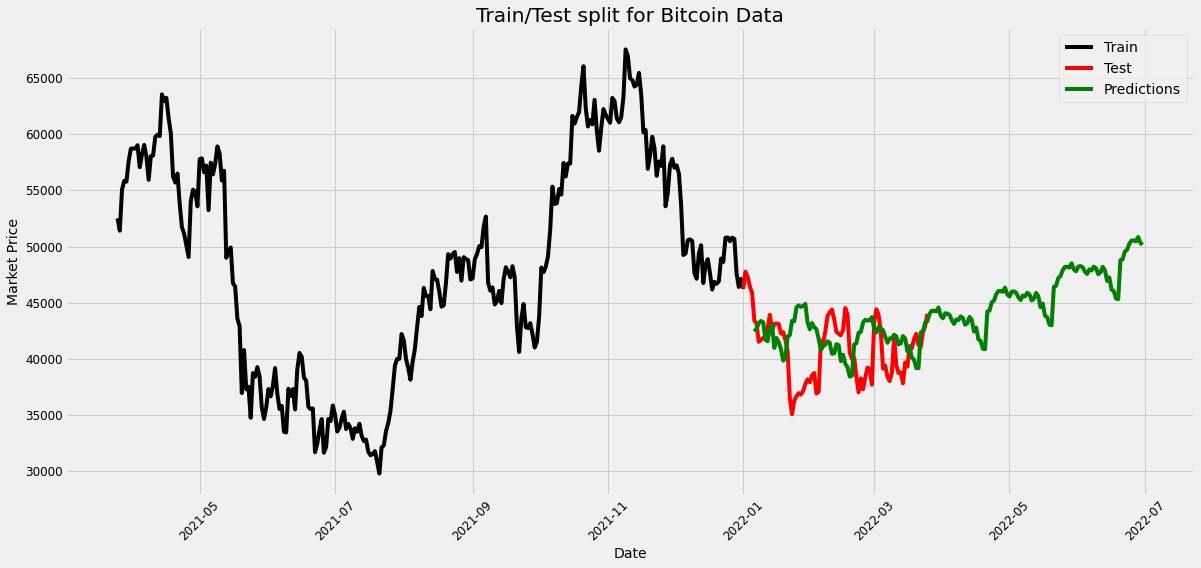

In [127]:
SARIMAXmodel = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(dates))
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df["Predictions"] = SARIMAXmodel.predict(start=dates[0],
                                                end=dates[-1])
y_pred_df.index = dates
y_pred_out = y_pred_df["Predictions"]

plt.plot(train, color="black", label='Train')
plt.plot(test, color="red", label='Test')
plt.ylabel('Market Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Bitcoin Data")

plt.plot(y_pred_out, color='green', label='Predictions')
plt.legend()
plt.show()

## Question 9: Predicting Price using Random Forest Regressor

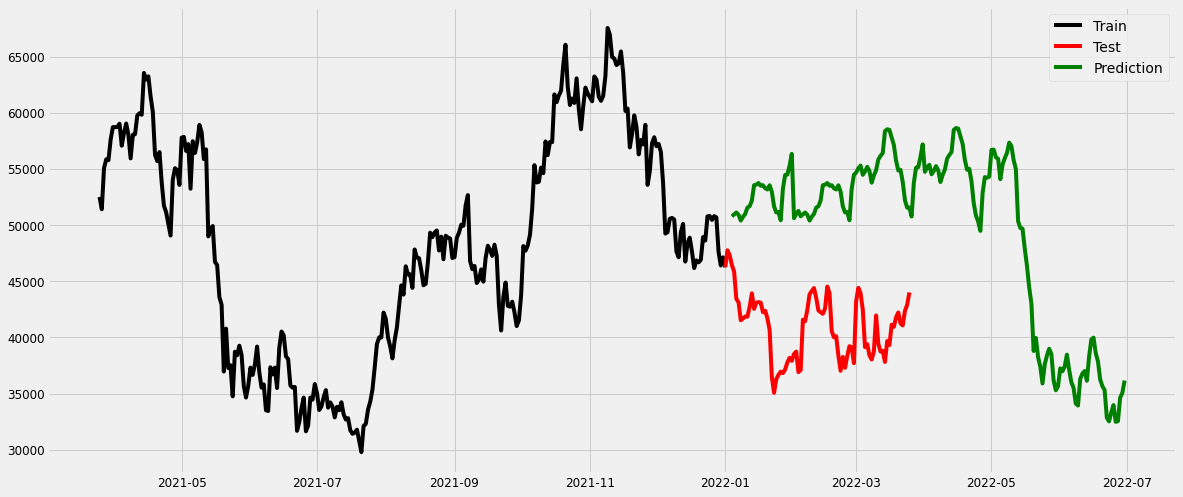

In [132]:
# convert into one matrix
test_X = np.array([t_day, t_months, t_years]).T

# fit the model
rfmodel = RandomForestRegressor(random_state=99)
rfmodel.fit(X, Y)

# predict on the same period
preds = rfmodel.predict(test_X)

# plot what has been learned
plt.plot(train.index, train.values, color="black", label='Train')
plt.plot(test.index, test.values, color="red", label='Test')
plt.plot(dates, preds, color="green", label='Prediction')
plt.legend()
plt.show()

## Question 10

***Visualization is already done***


There is a significant difference between the two predictions. SARIMAX model is predicting an increase in the price for the months April till June. However, Random forest is predicting a sharp decline in the market price of the Bitcoin. Since, SARIMAX has proved to be a better model, we can rely more on prediction made with SARIMAX model. 

# End of Assignment